# Assemble image pathnames and understand class breakdown in dataset

In [16]:
import numpy as np
from glob import glob
import torch

# Check quantities of train, validation and test images
train_images = np.array(glob("data/train/*/*"))
valid_images = np.array(glob("data/valid/*/*"))
test_images = np.array(glob("data/test/*/*"))

# Check relative percentages of image types
train_images_mel = np.array(glob("data/train/melanoma/*"))
train_images_nev = np.array(glob("data/train/nevus/*"))
train_images_seb = np.array(glob("data/train/seborrheic_keratosis/*"))

valid_images_mel = np.array(glob("data/valid/melanoma/*"))
valid_images_nev = np.array(glob("data/valid/nevus/*"))
valid_images_seb = np.array(glob("data/valid/seborrheic_keratosis/*"))

test_images_mel = np.array(glob("data/test/melanoma/*"))
test_images_nev = np.array(glob("data/test/nevus/*"))
test_images_seb = np.array(glob("data/test/seborrheic_keratosis/*"))

print("There are {} training images, {} validation images and {} test images.".format(len(train_images),len(valid_images),len(test_images)))
print("For the training images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(train_images_mel)/len(train_images)*100, mel2=len(train_images_mel),nev=len(train_images_nev)/len(train_images)*100, nev2=len(train_images_nev), seb=len(train_images_seb)/len(train_images)*100, seb2=len(train_images_seb)))
print("For the validation images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(valid_images_mel)/len(valid_images)*100, mel2=len(valid_images_mel),nev=len(valid_images_nev)/len(valid_images)*100, nev2=len(valid_images_nev), seb=len(valid_images_seb)/len(valid_images)*100, seb2=len(valid_images_seb)))
print("For the test images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(test_images_mel)/len(test_images)*100, mel2=len(test_images_mel),nev=len(test_images_nev)/len(test_images)*100, nev2=len(test_images_nev), seb=len(test_images_seb)/len(test_images)*100, seb2=len(test_images_seb)))

There are 2000 training images, 150 validation images and 600 test images.
For the training images, 18.7% (374) are of melanoma, 68.6% (1372) are of nevus and 12.7% (254) are for seborrheic keratosis.
For the validation images, 20.0% (30) are of melanoma, 52.0% (78) are of nevus and 28.0% (42) are for seborrheic keratosis.
For the test images, 19.5% (117) are of melanoma, 65.5% (393) are of nevus and 15.0% (90) are for seborrheic keratosis.


In [2]:
# Check for GPU support
use_cuda = torch.cuda.is_available()

# View random images to get a feel for what the dataset looks like

In [3]:
from PIL import Image 
import matplotlib.pyplot as plt                        
%matplotlib inline 

def plot_some_imgs(num_imgs_to_plot,dataset,dataset_name):
    print("Plotting {} images from dataset {}".format(num_imgs_to_plot,dataset_name))
    fig = plt.figure(figsize = (10,num_imgs_to_plot*2))
    axes = []
    for i in range(num_imgs_to_plot):
        img = Image.open(dataset[np.random.randint(0,len(dataset)-1)])
        axes.append(fig.add_subplot(num_imgs_to_plot/2,2,i+1))
        axes[-1].imshow(img)

Plotting 10 images from dataset Training Images Melanoma


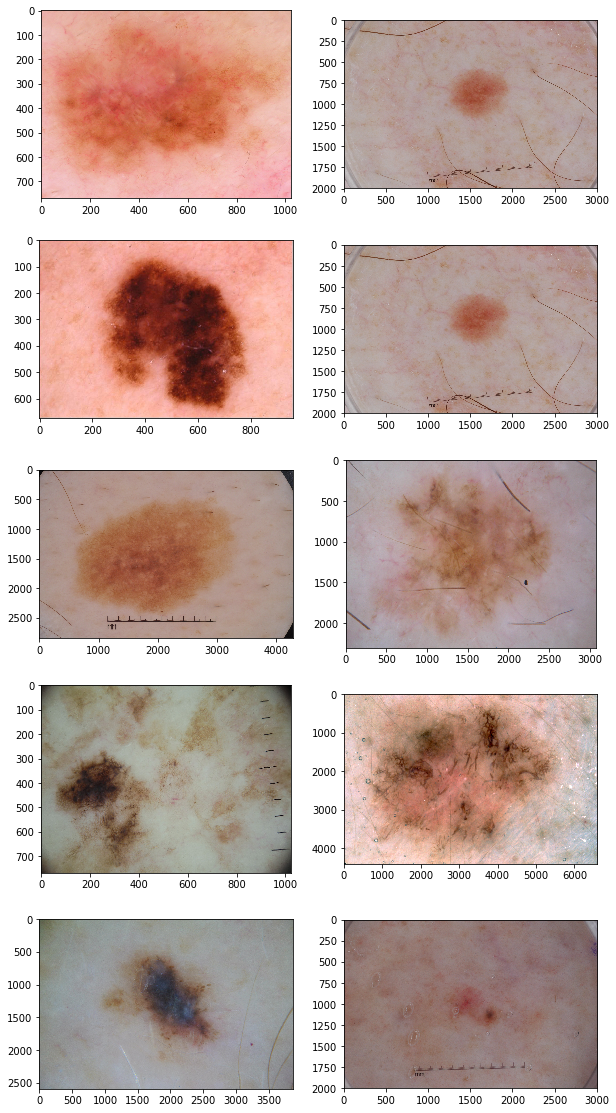

In [4]:
plot_some_imgs(10,train_images_mel,"Training Images Melanoma")

# Model Training

In [7]:
random_transforms = [transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomAffine(degrees=45,translate=(0.1,0.3),scale=(0.5,2))]

train_transforms = transforms.Compose([transforms.Resize(size=256),transforms.CenterCrop(224),transforms.RandomChoice(random_transforms), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

valid_test_transforms = transforms.Compose([transforms.Resize(size=256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])


# No data augmentation for the validation and test datasets, because we're using those as is for evaluation.
train_data = datasets.ImageFolder('data/train',transform=train_transforms)
validation_data = datasets.ImageFolder('data/valid',transform=valid_test_transforms)
test_data = datasets.ImageFolder('data/test',transform=valid_test_transforms)

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True)

validation_loader = torch.utils.data.DataLoader(validation_data)
test_loader = torch.utils.data.DataLoader(test_data)

loader_dict = {'train': train_loader, 'valid': validation_loader, 'test': test_loader}



In [ ]:
# Try a model
model = models.alexnet(pretrained=True)

In [10]:
# Freeze all parameters but the final layer
for param in model.features:
    param.requires_grad = False
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)

if use_cuda:
    model = model.cuda()

In [11]:
# Define optimizer and criterion
lr = 0.001
optimizer = optim.SGD(model.classifier.parameters(),lr = lr, momentum=0.2)
criterion = nn.CrossEntropyLoss()

In [12]:
# Check what the current best validation loss is.
def valid_check(model,loaders,criterion,use_cuda,save_path):
    model.load_state_dict(torch.load(save_path))
    model.eval()
    valid_loss = 0
    for batch_idx, (data, target) in enumerate(loaders['valid']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        ## update the average validation loss
        output = model.forward(data)
        loss = criterion(output,target)
        valid_loss += 1/(batch_idx+1)*(loss.data-valid_loss)

    # print training/validation statistics 
    print('Best validation loss to date: {:.6f}'.format(
        valid_loss
        ))

    return valid_loss
    

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = best_valid_loss
    update_every = 30
    
    for epoch in range(1, n_epochs+1):
        start = time.time()
        start2 = time.time()
        num_img1 = 0
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            check = time.time()
            if check-start2 > update_every:
                num_img2 = batch_idx*batch_size
                print("{} images left in this epoch. Average speed is {} imgs/sec.".format(len(train_images)-batch_idx*batch_size, (num_img2-num_img1)/update_every))
                start2 = time.time()
                num_img1 = num_img2
                
            
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model.forward(data)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += 1/(batch_idx+1)*(loss.data-train_loss)
        
        print("Epoch {} training time took {} seconds".format(epoch,time.time()-start))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model.forward(data)
            loss = criterion(output,target)
            valid_loss += 1/(batch_idx+1)*(loss.data-valid_loss)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [34]:
# Record the best validation loss achieved to date. 
model2 = model
best_valid_loss = valid_check(model2, loader_dict, criterion,use_cuda,'model_take1.pt')

Best validation loss to date: 0.788240


In [41]:
# train the model
model = train(5, loader_dict, model, optimizer, 
                      criterion, use_cuda, 'model_take1.pt')

1872 images left in this epoch. Average speed is 4.266666666666667 imgs/sec.
1616 images left in this epoch. Average speed is 8.533333333333333 imgs/sec.
1360 images left in this epoch. Average speed is 8.533333333333333 imgs/sec.
1104 images left in this epoch. Average speed is 8.533333333333333 imgs/sec.
848 images left in this epoch. Average speed is 8.533333333333333 imgs/sec.
592 images left in this epoch. Average speed is 8.533333333333333 imgs/sec.
336 images left in this epoch. Average speed is 8.533333333333333 imgs/sec.
Epoch 1 training time took 364.3330006599426 seconds
Epoch: 1 	Training Loss: 0.607626 	Validation Loss: 0.799365
1872 images left in this epoch. Average speed is 4.266666666666667 imgs/sec.
1616 images left in this epoch. Average speed is 8.533333333333333 imgs/sec.
1360 images left in this epoch. Average speed is 8.533333333333333 imgs/sec.
1104 images left in this epoch. Average speed is 8.533333333333333 imgs/sec.
848 images left in this epoch. Average spe

KeyboardInterrupt: 

In [14]:
# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_take1.pt'))

In [59]:
import csv
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    outputs = []
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        outputs.append(output)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    for i in range(len(outputs)):
        outputs[i] = outputs[i].cpu()
        outputs[i] = outputs[i].detach().numpy()
        outputs[i] = np.exp(outputs[i])/sum(np.exp(outputs[i])[0])
    
    with open('results.csv', 'w',newline='') as csvfile:
        resultswriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        resultswriter.writerow(['Id'] + ['task_1'] + ['task_2'])
        for i in range(len(outputs)):
            img = test_data.imgs[i]
            resultswriter.writerow([img[0]] + [str(outputs[i][0][0])] + [str(outputs[i][0][2])])
    print("Results saved to results.csv")


In [60]:
# call test function    
test(loader_dict, model, criterion, use_cuda)

Test Loss: 0.790499


Test Accuracy: 67% (406/600)
